In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
listing_data = pd.read_csv("./data/modelling_data")
listing_data.head()

,id,name,borough,neighbourhood,room_type_encoded,price,bathrooms,accommodates,bedrooms,beds,...,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",Brooklyn,Sunset Park,0,275,1.0,4,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5203,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,1,75,1.0,1,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,5121,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,1,60,1.0,2,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
3,5178,Large Furnished Room Near B'way,Manhattan,Midtown,1,68,1.0,2,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),Manhattan,East Harlem,1,65,1.0,1,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
listings = listing_data.drop(['id','name','borough','neighbourhood'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(listings.drop(columns='price'),
                                                    listings.price, test_size=0.3,
                                                    random_state=18)

In the previous step, the random forest regression with default parameters had the following performance metrics:
- R-squared: 0.46376569900475006
- RMSE: 120.93503657270503
- MAE: 68.84

I will perform a gridsearchCV to tune the parameters and calculate the new performance.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': np.arange(50,110,10),
    'max_depth': np.arange(5,25,5)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 90}
Best score: 0.5212151228939728


In [6]:
rfr = RandomForestRegressor(n_estimators=90, max_depth=15, random_state=18)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R-squared:", r2)
print("RMSE:", np.sqrt(mse))
mae = mean_absolute_error(y_test, y_pred)
print("Using these parameters, this random forest model's predictions would be off by an average of ${} from the true values".format(round(mae,2)))

R-squared: 0.5924246060147647
RMSE: 105.43354847548258
Using these parameters, this random forest model's predictions would be off by an average of $58.33 from the true values


# Engineering and adding more features 

The following are popular landmarks from each borough of New York City: <br>

- **Manhattan**: Empire State Building (40.7485° N, 73.9857° W)
- **Brooklyn**: Brooklyn Bridge (40.7061° N, 73.9969° W)
- **Queens**: Flushing Meadows-Corona Park (40.7400° N, 73.8407° W)
- **The Bronx**: Yankee Stadium (40.8296° N, 73.9262° W)
- **Staten Island**: Staten Island Ferry (40.6437° N, 74.0719° W)

In [30]:
coordinate_data = pd.read_csv('./data/coordinate_data')
coordinate_data.head()

,id,name,longitude,latitude,price,borough
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",-73.99454,40.66265,275,Brooklyn
1,5203,Cozy Clean Guest Room - Family Apt,-73.96751,40.80380,75,Manhattan
2,5121,BlissArtsSpace!,-73.95512,40.68535,60,Brooklyn
3,5178,Large Furnished Room Near B'way,-73.98317,40.76457,68,Manhattan
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),-73.94255,40.80107,65,Manhattan


In [31]:
landmarks = {
    'Manhattan': {'name': 'Empire State Building', 'lat': 40.7485, 'lon': -73.9857},
    'Brooklyn': {'name': 'Brooklyn Bridge', 'lat': 40.7061, 'lon': -73.9969},
    'Queens': {'name': 'Flushing Meadows - Corona Park', 'lat': 40.7400, 'lon': -73.8407},
    'Bronx': {'name': 'Yankee Stadium', 'lat': 40.8296, 'lon': -73.9262},
    'Staten Island': {'name': 'Staten Island Ferry', 'lat': 40.6437, 'lon': -74.0719}
}

In [32]:
import math

# defining a function to calculate the distance between a listing and its respective landmark
def haversine_distance(row):
    # getting the name and coordinate of landmark for the borough of the listing
    borough = row['borough']
    landmark_name = landmarks[borough]['name']
    landmark_lat = landmarks[borough]['lat']
    landmark_lon = landmarks[borough]['lon']

    # getting the lat and lon of the listing
    lat = row['latitude']
    lon = row['longitude']
    
    # converting the lat and lon to radians
    lat, lon, landmark_lat, landmark_lon = map(math.radians, [lat, lon, landmark_lat, landmark_lon])

    # Haversine formula
    dlon = landmark_lon - lon
    dlat = landmark_lat - lat
    a = math.sin(dlat / 2) ** 2 + math.cos(lat) * math.cos(landmark_lat) * math.sin(dlon / 2) ** 2
    c = 2 *math.asin(math.sqrt(a))
    r = 6371 # earth radius
    distance = c * r
    return distance, landmark_name

In [33]:
# Calculate the distance between each listing and its respective landmark
coordinate_data[['landmark_distance_km', 'landmark_name']] = coordinate_data.apply(haversine_distance, axis=1, result_type='expand')

In [34]:
coordinate_data.head()

,id,name,longitude,latitude,price,borough,landmark_distance_km,landmark_name
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",-73.99454,40.66265,275,Brooklyn,4.835516,Brooklyn Bridge
1,5203,Cozy Clean Guest Room - Family Apt,-73.96751,40.80380,75,Manhattan,6.336971,Empire State Building
2,5121,BlissArtsSpace!,-73.95512,40.68535,60,Brooklyn,4.210733,Brooklyn Bridge
3,5178,Large Furnished Room Near B'way,-73.98317,40.76457,68,Manhattan,1.799564,Empire State Building
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),-73.94255,40.80107,65,Manhattan,6.882754,Empire State Building


In [41]:
listing_data.head()

,id,name,borough,neighbourhood,room_type_encoded,price,bathrooms,accommodates,bedrooms,beds,...,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",Brooklyn,Sunset Park,0,275,1.0,4,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5203,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,1,75,1.0,1,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,5121,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,1,60,1.0,2,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
3,5178,Large Furnished Room Near B'way,Manhattan,Midtown,1,68,1.0,2,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),Manhattan,East Harlem,1,65,1.0,1,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [73]:
list(listing_data.columns)

['id',
 'name',
 'borough',
 'neighbourhood',
 'room_type_encoded',
 'price',
 'bathrooms',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'availability_365',
 'neighbourhood_Arden Heights',
 'neighbourhood_Arrochar',
 'neighbourhood_Arverne',
 'neighbourhood_Astoria',
 'neighbourhood_Bath Beach',
 'neighbourhood_Battery Park City',
 'neighbourhood_Bay Ridge',
 'neighbourhood_Bay Terrace',
 'neighbourhood_Baychester',
 'neighbourhood_Bayside',
 'neighbourhood_Bayswater',
 'neighbourhood_Bedford-Stuyvesant',
 'neighbourhood_Belle Harbor',
 'neighbourhood_Bellerose',
 'neighbourhood_Belmont',
 'neighbourhood_Bensonhurst',
 'neighbourhood_Bergen Beach',
 'neighbourhood_Boerum Hill',
 'neighbourhood_Borough Park',
 'neighbourhood_Breezy Point',
 'neighbourhood_Briarwood',
 'neighbourhood_Brighton Beach',
 'neighbourhood_Bronxdale',
 'neighbourhood_Brooklyn Heights',
 'neighbourhood_Brownsville',
 "neighbourhood_Bull's Head",
 'neighbourhood_Bushwick',
 'neighbourhood_Cambria He

In [45]:
df = pd.merge(listing_data, coordinate_data[['landmark_distance_km','id']], on=['id'], how='left')

In [46]:
df.head()

,id,name,borough,neighbourhood,room_type_encoded,price,bathrooms,accommodates,bedrooms,beds,...,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,landmark_distance_km
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",Brooklyn,Sunset Park,0,275,1.0,4,2.0,2.0,...,0,0,0,0,0,1,0,0,0,4.835516
1,5203,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,1,75,1.0,1,1.0,1.0,...,0,0,0,0,0,0,1,0,0,6.336971
2,5121,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,1,60,1.0,2,1.0,1.0,...,0,0,0,0,0,1,0,0,0,4.210733
3,5178,Large Furnished Room Near B'way,Manhattan,Midtown,1,68,1.0,2,1.0,1.0,...,0,0,0,0,0,0,1,0,0,1.799564
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),Manhattan,East Harlem,1,65,1.0,1,1.0,1.0,...,0,0,0,0,0,0,1,0,0,6.882754


In [47]:
df.drop(["id","name", "borough", "neighbourhood"], axis=1, inplace=True)

In [48]:
df.head()

,room_type_encoded,price,bathrooms,accommodates,bedrooms,beds,minimum_nights,availability_365,neighbourhood_Arden Heights,neighbourhood_Arrochar,...,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,landmark_distance_km
0,0,275,1.0,4,2.0,2.0,21,267,0,0,...,0,0,0,0,0,1,0,0,0,4.835516
1,1,75,1.0,1,1.0,1.0,2,0,0,0,...,0,0,0,0,0,0,1,0,0,6.336971
2,1,60,1.0,2,1.0,1.0,30,322,0,0,...,0,0,0,0,0,1,0,0,0,4.210733
3,1,68,1.0,2,1.0,1.0,2,79,0,0,...,0,0,0,0,0,0,1,0,0,1.799564
4,1,65,1.0,1,1.0,1.0,30,300,0,0,...,0,0,0,0,0,0,1,0,0,6.882754


In [49]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [50]:
param_grid = {
    'n_estimators': np.arange(50,110,10),
    'max_depth': np.arange(5,25,5)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 70}
Best score: 0.6473112956586872


As this Grid Search produced a better score than the previous, I will use the new best parameters.

In [51]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=70, max_depth=15, random_state=18)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [52]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R-squared:", r2)
print("RMSE:", np.sqrt(mse))
mae = mean_absolute_error(y_test, y_pred)
print("This random forest model's predictions would be off by an average of ${} from the true values".format(round(mae,2)))

R-squared: 0.6182738771966685
RMSE: 102.03537982599381
This random forest model's predictions would be off by an average of $56.19 from the true values


This model's performance has been the best so far. 

Finally, I'll try the popular gradient boosting model with XGBoost to see if it improves upon the RandomForest.

In [53]:
import xgboost as xgb

# Define the parameter grid to search over
param_grid = {
    'max_depth': np.arange(3,8),
    'learning_rate': [0.01, 0.05, 0.1,0.3],
    'n_estimators': [50,100,200]
}

# Create an XGBoost regressor object
xgb_reg = xgb.XGBRegressor()

# Use GridSearchCV to search over the parameter grid
grid_search = GridSearchCV(
    estimator=xgb_reg, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [54]:
# Evaluate the model on the test data
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")
print("The best model's predictions would be off by an average of ${} from the true values".format(round(mae,2)))

Root mean squared error: 100.97543831461905
The best model's predictions would be off by an average of $56.36 from the true values


So the performance slightly dropped with the XGB model. The best model is the RFR with the added landmark proximity feature.

## Feature Analysis

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Train the random forest regression model with your chosen hyperparameters
model = rfr
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Get the indices of features sorted in descending order of importance
indices = np.argsort(importances)[::-1]


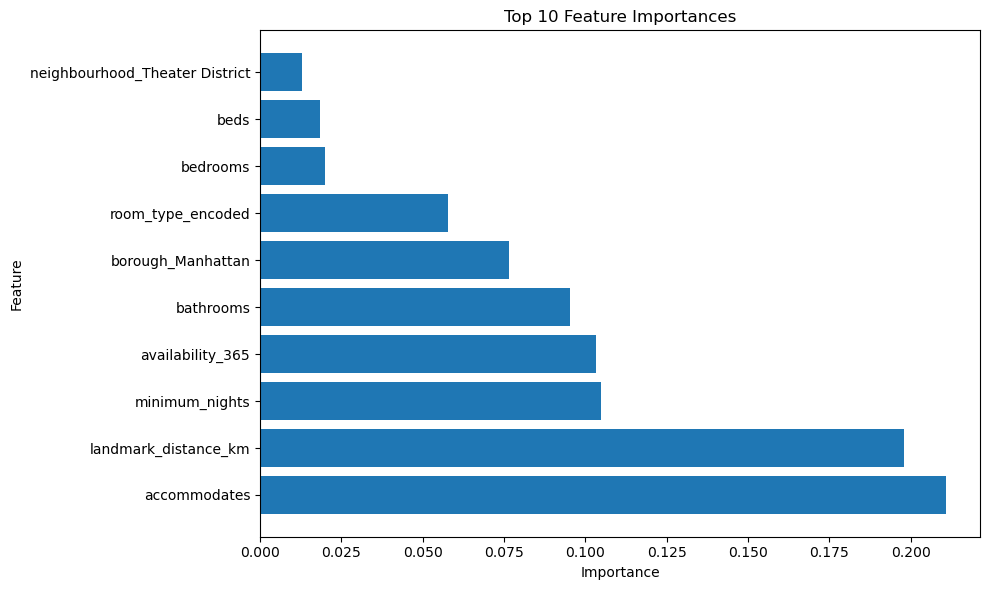

In [56]:
# Plot feature importances and select the top 10 features
top_features = 10
indices = indices[:top_features]
importances = importances[indices]
feature_names = X_train.columns[indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances, align='center')
plt.yticks(range(len(indices)), feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [19]:
# Group the DataFrame by 'borough' and 'beds' and calculate the average price
df_avg_price = listing_data.groupby(['borough', 'beds'])['price'].mean().reset_index()

df2 = pd.merge(listing_data, df_avg_price, on=['borough', 'beds'], how='left')
df2.rename(columns={'price_y': 'y_naive', 'price_x':'price'}, inplace=True)


In [64]:
df2.head()

,id,name,borough,neighbourhood,room_type_encoded,price,bathrooms,accommodates,bedrooms,beds,...,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,y_naive
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",Brooklyn,Sunset Park,0,275,1.0,4,2.0,2.0,...,0,0,0,0,0,1,0,0,0,182.398798
1,5203,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,1,75,1.0,1,1.0,1.0,...,0,0,0,0,0,0,1,0,0,192.359605
2,5121,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,1,60,1.0,2,1.0,1.0,...,0,0,0,0,0,1,0,0,0,108.920051
3,5178,Large Furnished Room Near B'way,Manhattan,Midtown,1,68,1.0,2,1.0,1.0,...,0,0,0,0,0,0,1,0,0,192.359605
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),Manhattan,East Harlem,1,65,1.0,1,1.0,1.0,...,0,0,0,0,0,0,1,0,0,192.359605


## Profitability Analysis

To do this, I will need to make the naive assumption that the company's best model uses the mean price for the respective borough as an estimator of price. 

The will conduct a comparison of the profitability by considering different scenarios.

First, I will by assuming a potential decrease in bookings when my predicted price is higher than the company's assumption. Next I will:

- Calculate the profitability of my model's predictions taking into account the potential decrease in bookings.

- Calculate the profitability of the company's model (mean price for neighbourhood & beds) without considering any decrease in bookings.

- Compare profitability results by calculating the difference in profits between the two scenarios.

Finally, I will analyze the profit difference to understand the impact of my model's predictions. 

If the profit difference is positive, that indicates my model's predictions generates higher profit despite the potential decrease in bookings. 

From http://insideairbnb.com/data-assumptions - we can estimate the occupancy rate by using the "San Francisco Model":
1. Calculate the **estimated bookings** (assuming a 50% review response rate): multiply number of reviews by 2.
2. Calculate **average length of stay**, use minimum nights value if available, otherwise use (3).
3. Calculate **occupancy rate**: min(Estimated bookings * Average length of stay / minimum nights)
4. Cap Occupancy Rate: "To maintain a conservative approac and control for potential annomalies, cap the occupancy rate at a reasonable level (70%).

In [57]:
from datetime import datetime

df_occupancy = pd.read_csv("./data/calendar.csv", low_memory=False)
df_occupancy.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5136,2022-12-04,f,$275.00,$275.00,21.0,1125.0
1,2595,2022-12-05,t,$175.00,$175.00,30.0,1125.0
2,2595,2022-12-06,t,$175.00,$175.00,30.0,1125.0
3,2595,2022-12-07,t,$175.00,$175.00,30.0,1125.0
4,2595,2022-12-08,t,$175.00,$175.00,30.0,1125.0


In [58]:
df_occupancy['date'] = pd.to_datetime(df_occupancy['date'])

In [60]:
available_listings = df_occupancy[df_occupancy['available'] == 't']
available_days = available_listings.groupby('listing_id')['date'].nunique().reset_index()
available_days.rename(columns={'date': 'available_days'}, inplace=True)
available_days.head()

,listing_id,available_days
0,2595,365
1,5121,322
2,5136,267
3,5178,79
4,5803,163


In [62]:
total_days = df_occupancy.groupby('listing_id')['date'].nunique().reset_index()
total_days.rename(columns={'date': 'total_days'}, inplace=True)

In [63]:
occupancy = pd.merge(total_days, available_days, on='listing_id')
occupancy['occupancy_rate'] = ((occupancy['total_days'] - occupancy['available_days']) / occupancy['total_days']) * 100

In [70]:
merged = pd.merge(occupancy[['occupancy_rate','listing_id']], df2, left_on='listing_id', right_on='id')

In [72]:
list(merged.columns)

['occupancy_rate',
 'listing_id',
 'id',
 'name',
 'borough',
 'neighbourhood',
 'room_type_encoded',
 'price',
 'bathrooms',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'availability_365',
 'neighbourhood_Arden Heights',
 'neighbourhood_Arrochar',
 'neighbourhood_Arverne',
 'neighbourhood_Astoria',
 'neighbourhood_Bath Beach',
 'neighbourhood_Battery Park City',
 'neighbourhood_Bay Ridge',
 'neighbourhood_Bay Terrace',
 'neighbourhood_Baychester',
 'neighbourhood_Bayside',
 'neighbourhood_Bayswater',
 'neighbourhood_Bedford-Stuyvesant',
 'neighbourhood_Belle Harbor',
 'neighbourhood_Bellerose',
 'neighbourhood_Belmont',
 'neighbourhood_Bensonhurst',
 'neighbourhood_Bergen Beach',
 'neighbourhood_Boerum Hill',
 'neighbourhood_Borough Park',
 'neighbourhood_Breezy Point',
 'neighbourhood_Briarwood',
 'neighbourhood_Brighton Beach',
 'neighbourhood_Bronxdale',
 'neighbourhood_Brooklyn Heights',
 'neighbourhood_Brownsville',
 "neighbourhood_Bull's Head",
 'neighbourhood_Bus

In [68]:
merged_analysis = merged.drop(['listing_id','id','neighbourhood','borough', 'name'], axis=1)

In [69]:
merged_data.head()

,occupancy_rate,room_type_encoded,price,bathrooms,accommodates,bedrooms,beds,minimum_nights,availability_365,neighbourhood_Arden Heights,...,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,y_naive
0,11.780822,1,60,1.0,2,1.0,1.0,30,322,0,...,0,0,0,0,0,1,0,0,0,108.920051
1,26.849315,0,275,1.0,4,2.0,2.0,21,267,0,...,0,0,0,0,0,1,0,0,0,182.398798
2,78.356164,1,68,1.0,2,1.0,1.0,2,79,0,...,0,0,0,0,0,0,1,0,0,192.359605
3,55.342466,1,124,1.0,2,1.0,1.0,4,163,0,...,0,0,0,0,0,1,0,0,0,108.920051
4,17.808219,1,65,1.0,1,1.0,1.0,30,300,0,...,0,0,0,0,0,0,1,0,0,192.359605


# NEXT STEPS

#### 1. Additional feature engineering:
  - Using `amenities` as an additional feature.
  - Using another encooding method for `room_type`
  - Using different landmarks - possibly extracted from the `name` feature if available


#### 2. Apply models on other cities 

